In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import numpy as np
import pandas as pd

from PIL import Image

from sklearn.model_selection import train_test_split

import torch.nn as nn
from torchvision import models
import torch.optim as optim
from tqdm import tqdm

In [2]:
model = models.resnet18(pretrained=True)

classifier = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(512, 1000)
)

model.fc = classifier

c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\janko\OneDrive\Pulpit\Artificial intelligence\Magisterka\topography-public\venv_torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# load the model from state_dict
model.load_state_dict(torch.load('../models/final_model_best.pth'))
model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
class ImageDataset(Dataset):
    def __init__(self, path: str, parameters: pd.DataFrame, transform=None) -> None:
        self.image_paths = np.array([path + filename for filename in parameters['filename'].to_numpy()])
        self.labels = parameters['epsilon'].to_numpy()
        self.transform = transform

    def __getitem__(self, inx):
        image_path = self.image_paths[inx]
        label_float_epsilon = self.labels[inx]
        target = np.zeros(shape=(1000,))
        target[int(label_float_epsilon*1000)] = 1
        image = Image.open(image_path)
        image = np.array(image)
        # repeat grayscale value three times for all RGB channels
        image = np.repeat(image[..., np.newaxis], 3, -1)
        if self.transform:
            image = self.transform(image)
        return image, torch.from_numpy(target)

    def __len__(self):
        return len(self.image_paths)

In [5]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [6]:
# Prepare a function for a single image inference
# Return predicted epsilon value
def predict(image_path: str):
    image = Image.open(image_path)
    image = np.array(image)
    image = np.repeat(image[..., np.newaxis], 3, -1)
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.cuda()
    with torch.no_grad():
        output = model(image)
    return torch.argmax(output).item()/1000

In [9]:
path = "../data/raw/steel/1channel/"
# scan directory and create a list with filenames
import os
files = os.listdir(path)
files = files[:-1]

In [10]:
len(files)

100000

In [11]:
predictions = []
from tqdm import tqdm
for file in tqdm(files):
    predictions.append(predict(path + file))

100%|██████████| 100000/100000 [15:17<00:00, 108.99it/s]


In [12]:
pd.DataFrame({"filename": files, "epsilon": predictions}).to_csv("../data/results/best_ceramic_model_4_steel.csv", index=False)

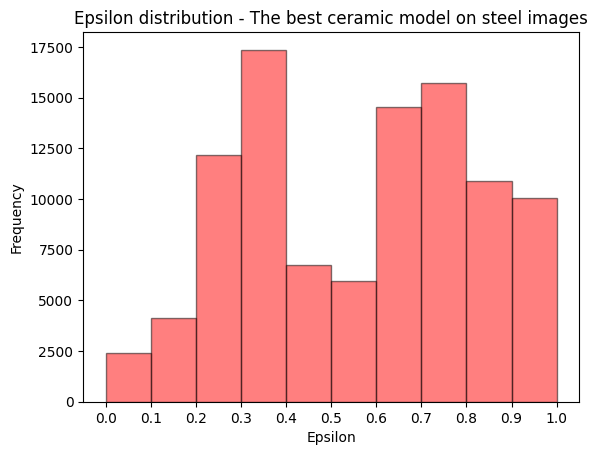

In [15]:
import matplotlib.pyplot as plt

steel = pd.read_csv('../data/results/best_ceramic_model_4_steel.csv')
plt.hist(steel['epsilon'], bins=10, range=(0, 1), color='red', alpha=0.5, edgecolor='black')
plt.title('Epsilon distribution - The best ceramic model on steel images')
plt.xlabel('Epsilon')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()